In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
NumExpr defaulting to 8 threads.


In [2]:
#tstamp = '13_12_2019_10_18'
tstamp

'27_01_2020_12_28'

In [3]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [4]:
# lcs = pd.Series({"rad":pd.Series([(2.1*R_jup/R_sun).decompose().value]),
#                 "Prot_d":pd.Series([2.84/24]),
#                 "vsini_kms":pd.Series([49.2]),
#                 "e_vsini_kms":pd.Series([4.9]),})
# get_incl(lcs), lcs.rad.values

In [5]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
#guesses = pd.read_csv(f"{CWD}/archive/eyeball_results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)


In [6]:
#lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [7]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126
6,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,0.055900,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,13.5557,9.854,8.950


In [8]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[6]
target

ID                    230120143
QCS                          16
typ                         slc
cadence_min                   2
mission                    tess
prefix                      TIC
origin                  generic
h_mission                  TESS
SpT                          M7
view_start                 1741
view_stop                  1743
view_min                   2320
view_max                   2500
BJDoff                  2457000
tstart                   1741.6
ampl_min                    1.5
ampl_max                    2.5
RA                      250.086
Dec                     67.6013
J                         9.854
R                           NaN
Gaia_G                   13.557
vsini_kms                  10.8
e_vsini_kms                 0.7
Prot_d                 0.378325
sini                  0.6844128
Ref                Kesseli+2018
identifier                  NaN
Rstar                       NaN
idtyp                      tess
id                    230120143
st      

5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).
5% (953/17765) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


TIC 230120143 modulation period:  9.089056409968848 h
Relative amplitude of modulation: -4.7e-03
[1738.65173791 1738.6531268  1738.65451569 ... 1763.31571967 1763.31710857
 1763.31849747]
[11.266142 11.266142 11.266142 ... 11.266142 11.266142 11.266142]


2352.813933074617

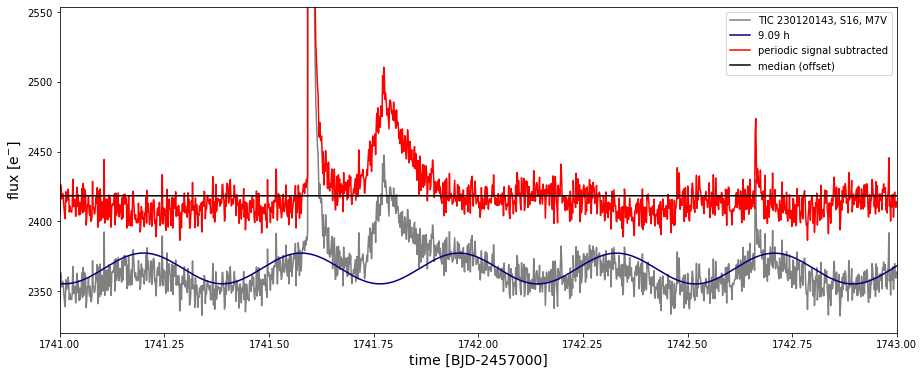

In [11]:
from altaipony.altai import find_iterative_median
from altaipony.flarelc import FlareLightCurve
from funcs.custom_detrending import refine_detrended_flux_err
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve

flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False, cut=[target.view_start-5,target.view_stop+5])
print(t)
F = FlareLightCurve(time=t, detrended_flux=sflux, 
                    detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
print(F.detrended_flux_err)
flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
                                     std_rolling_window_length=15, pad=25)

choice = (t > target.view_start ) & (t < target.view_stop) # only one flare in TIC 237 : + 1.56 - 1.
t = t[choice]
flux = sflux[choice]
flux_err = np.nanmean(flcd.detrended_flux_err)
median = np.nanmean(find_iterative_median(F).it_med-10)
phi = (t - t[0])/target.Prot_d * 2 * np.pi

pd.DataFrame({"phi":phi,"flux":flux, "t":t,
              "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
                                                             index=False)
median

1440

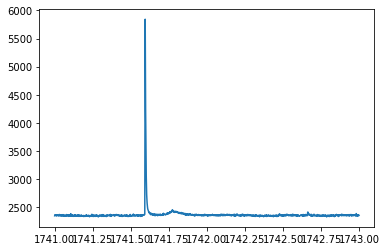

In [12]:
plt.plot(t,flux)
len(t)

In [13]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median

2352.813933074617

(0.3490658503988659, 0.5897363823146299, 9.90861031516944, 18.13832327589945)

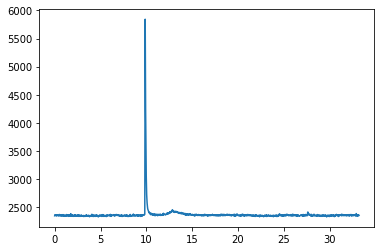

In [84]:

phi_a = (target.tstart+0.006 - t[0])/target.Prot_d * 2 * np.pi-.15
theta_a = 20*np.pi/180#target.theta_a_init
a = 2.5
fwhm =  .04/target.Prot_d * 2 * np.pi
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 85 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = phi[-1]
plt.plot(phi,flux)
radius = calculate_angular_radius(Fth, a, qlum, R,)
theta_a, i_mu, phi_a, radius


(2300, 7500)

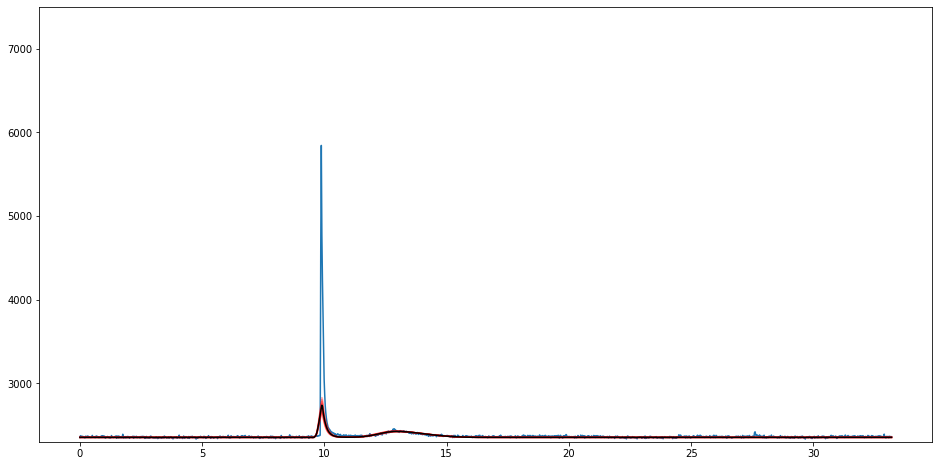

In [90]:

plt.figure(figsize=(16,8))
plt.plot(phi,flux)
for i in range(80,90,1):
    plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=.31,)
plt.plot(phi, full_model(phi_a, theta_a, a, fwhm, i_mu, phi0=85 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(2300,7500)

### Save inits

In [86]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [87]:

inits = np.array([phi_a, theta_a, a, fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 6))
nwalkers, ndim = pos.shape

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [88]:
tstamp, filename

('27_01_2020_12_28',
 '/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/results/mcmc/27_01_2020_12_28_230120143_MCMC.h5')

In [89]:

sampler.run_mcmc(pos, 50000, progress=True, store=True);

100%|██████████| 50000/50000 [37:58:22<00:00,  2.73s/it]   


In [ ]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

In [ ]:
tstamp, target.ID

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))

In [ ]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED